In [1]:
import numpy as np
import pandas as pd
import os
import json

In [2]:
df = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\df_merged.csv")
ea_data = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\Data_computed_properties\filtered_ip.csv")
ea_data.dropna(inplace=True)
ea_data.rename(columns={'solvent ID': 'solvent_ID', 'IP_0-1': 'IP_values'}, inplace=True)
df = df.merge(ea_data, on=['solvent_ID'], how="right")

In [3]:
df.head()

,solvent_ID,smiles_x,Binding_Energy_eV,solubility_CO2 [mol/L],viscosity [Pa s],nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,polarizability_ang3,min_partial_charge,max_partial_charge,min_abs_partial_charge,max_abs_partial_charge,vib_freq_min_cm1,vib_freq_max_cm1,vib_freq_count,smiles_y,IP_values
0,zinc_1345620175,C[C@H]([C@@H](N[C@@H]1CCCC[C@H]1F)C)O,-0.214742,0.079341,0.150835,0.0,1.0,15.711170,2.269900,4.539800,...,849.696107,-0.819411,0.453256,0.172385,0.819411,51.2361,3727.7322,93.0,C[C@H](N[C@@H]1CCCC[C@H]1F)[C@@H](C)O,0.724053
1,zinc_674912368,COC[C@@H](N1C[C@H]2[C@H](C1)CCC2)C,-0.214342,0.094735,0.011400,0.0,1.0,16.309342,2.417049,4.559183,...,924.031534,-0.779818,0.232699,0.000737,0.779818,35.7164,3128.8524,96.0,COC[C@H](C)N1C[C@@H]2CCC[C@H]2C1,0.255187
2,zinc_644654185,CC[C@H](CNCC(F)(F)C)O,-0.212998,0.096515,0.022542,0.0,1.0,11.751232,2.135779,4.271558,...,666.772267,-0.824957,0.633432,0.059057,0.824957,43.3486,3716.1399,72.0,CC[C@@H](O)CNCC(C)(F)F,1.070564
3,zinc_132906027,CC[C@H](C1CC1)NCCOCC(C)C,-0.215950,0.079947,0.004861,0.0,1.0,17.214239,2.324807,4.407461,...,1044.297027,-0.927964,0.380666,0.011509,0.927964,22.3711,3510.5041,111.0,CC[C@@H](NCCOCC(C)C)C1CC1,0.763281
4,zinc_156549661,C[C@@H](CN1CCC[C@H]1C)O,-0.198320,0.088578,0.081929,0.0,1.0,11.731206,2.268815,4.387099,...,709.790668,-0.610850,0.449006,0.051486,0.610850,43.4119,3722.5285,75.0,C[C@H](O)CN1CCC[C@H]1C,0.313528


In [4]:
df.rename(columns={'smiles_x': 'smiles'}, inplace=True)
df.drop("smiles_y", inplace=True, axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Columns: 1421 entries, solvent_ID to IP_values
dtypes: float64(1419), object(2)
memory usage: 33.6+ MB


In [6]:
# df = df[(df["IP_values"] > -2) & (df["IP_values"] < 6)]

In [7]:
meta_cols = ['solvent_ID', 'smiles', 'solubility_CO2 [mol/L]', 'viscosity [Pa s]', 'Binding_Energy_eV']
target = 'IP_values'  # or 'solubility_CO2 [mol/L]', 'viscosity [Pa s]'
X = df.drop(columns=meta_cols + [target])
y = df[target]

<Axes: >

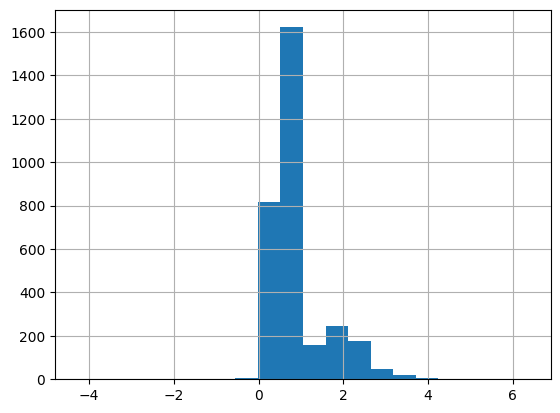

In [8]:
y.hist(bins=20)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y_scaler = StandardScaler()
# y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

from sklearn.preprocessing import PowerTransformer

# Step 1: Initialize transformer
pt = PowerTransformer(method='yeo-johnson')

# Step 2: Fit and transform the target (y_train), transform y_test
# y_train_trans = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_test_trans = pt.transform(y_test.values.reshape(-1, 1)).flatten()

# 4. Model Training
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train_log)

<Axes: xlabel='IP_values', ylabel='Count'>

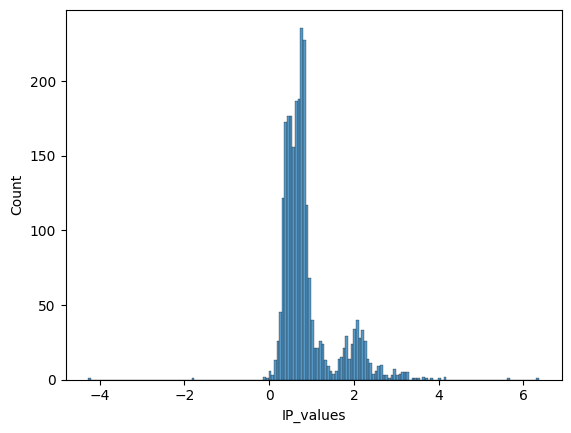

In [12]:
import seaborn as sns
sns.histplot(y_train)

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# # XGB model with GPU support
from xgboost import XGBRegressor
xgb = XGBRegressor(
    tree_method='gpu_hist',  # key line for GPU
    device='cuda', 
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 0.5, 1, 5]
}


# # RandomizedSearchCV with GPU-based XGBoost
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=1,
    n_jobs=1  # must be 1 when using GPU with XGBoost
)

# # Train the model
random_search.fit(X_train_scaled, y_train)

# Evaluate best model
# best_model = random_search.best_estimator_

# model = XGBRegressor(
#     tree_method='gpu_hist',
#     device='cuda',
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=10,
#     learning_rate=0.01,
#     n_estimators=500,
#     max_depth=6,
#     random_state=42
# )

# model.fit(X_train_scaled, y_train_log)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:59:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:2676: UserWarning: [00:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:729: UserWarning: [00:59:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to predic

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constra...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_lambda': [0.1, 0.5, 1, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [15]:
best_params = random_search.best_params_
final_model = XGBRegressor(
    **best_params,
    tree_method='gpu_hist',
    device='cuda',
    random_state=42
)

In [16]:
final_model.fit(
    X_train_scaled,
    y_train,
    verbose=True
)

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:34:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
final_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)>

In [ ]:

# 5. Evaluation
# y_pred_log = model.predict(X_test_scaled)
# ------------------- Step 5: Predict and Inverse Transform ------------------- #
y_pred_orig = final_model.predict(X_test_scaled)
# y_pred_trans = final_model.predict(X_test_scaled)

# Inverse transform predictions back to original scale
# y_pred_orig = pt.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
# y_pred_orig = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
# Inverse log1p
# y_pred = np.expm1(y_pred_log)
# y_test = np.expm1(y_test)

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred_orig))
r2 = r2_score(y_test, y_pred_orig)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.2599
R² Score: 0.8529


c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\xgboost\core.py:2676: UserWarning: [01:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [19]:
feature_names = X.columns.tolist()  # This should match the model's input

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


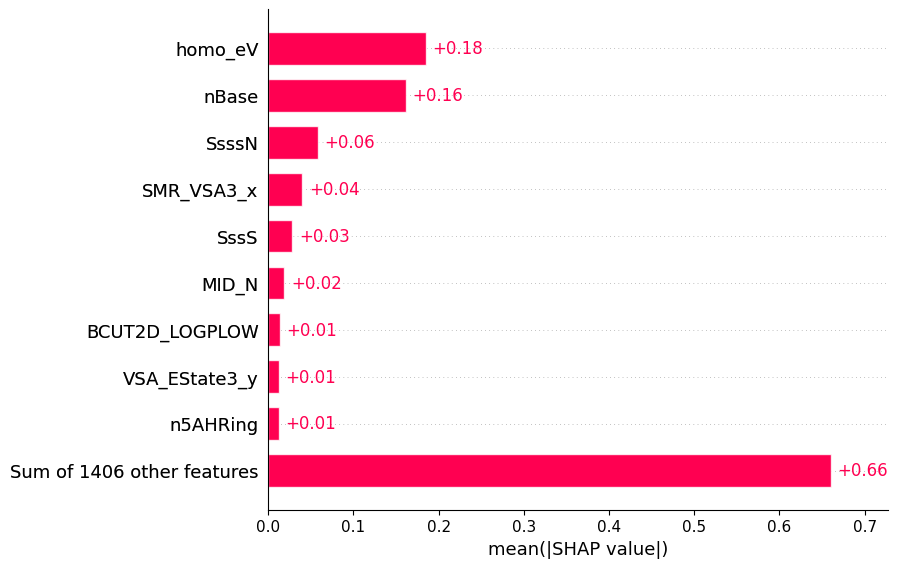

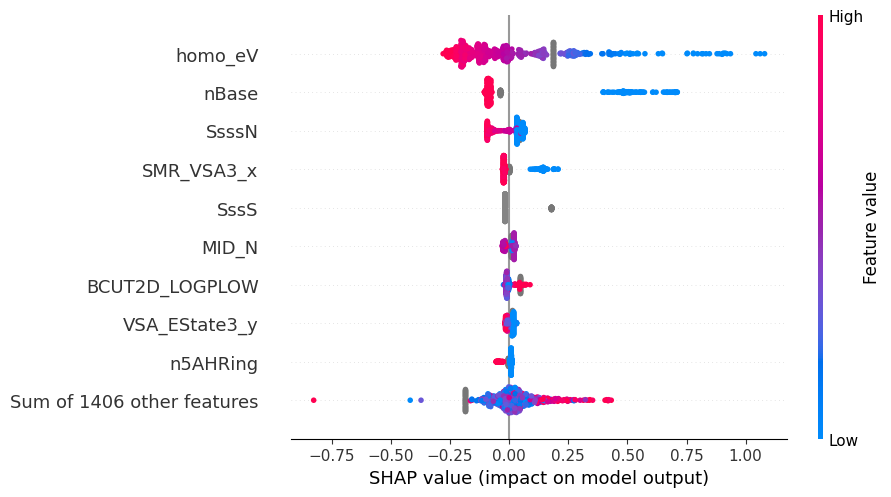

In [20]:
import shap

explainer = shap.Explainer(final_model, X_test_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

shap.plots.bar(shap_values, max_display=10)
shap.plots.beeswarm(shap_values, max_display=10)

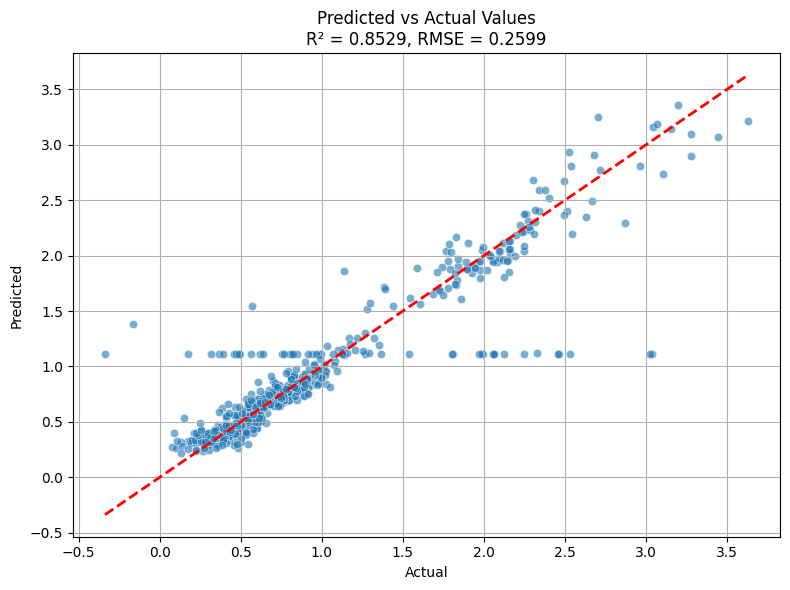

In [21]:
residuals = y_test - y_pred_orig

import matplotlib.pyplot as plt
import seaborn as sns 

# --- A. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_orig, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.title(f"Predicted vs Actual Values\nR² = {r2:.4f}, RMSE = {rmse:.4f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

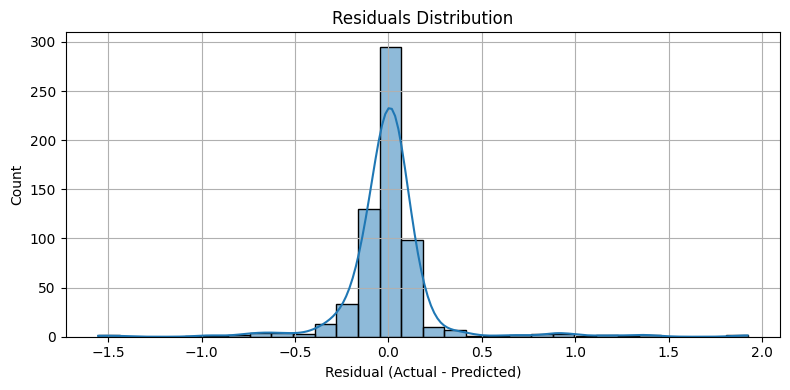

In [22]:
# --- B. Histogram of Residuals ---
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()